In [5]:
#Importing Libraries
import saha_mult #Class used to calculate abundances 
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
from time import process_time #Useful for finding calculation times
import pickle #for saving data in lists to txt files.

import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook

<module 'saha_mult' from 'C:\\Users\\prana\\Documents\\Research\\R-process_Mergers\\Abundance_Calculations\\Total Charge State Abundances\\saha_mult.py'>

In [6]:
#This function here will return all the ionization potentials of the desired elements. Enter the starting element and
#ending element Z number. This will return an array of arrays. Note the starting position of the array!

#The way I did this was similar to the Multiple Elements Scenario code, but I added an extra array called 
#returned_potentials, which is designed to return an array of all the desired potentials we wanted
nist = pd.read_excel("NIST Data Table.xlsx")
ion_energies1d =  nist[' Ionization  Energy (eV)']

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()

        for j in range(i):

            if isinstance(ion_energies1d[counter],str):

                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 

                    for k in ion_energies1d[counter]:

                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k

                    specific_list.append(np.abs(float(str_num)))
                    counter+=1


            else:
                specific_list.append(np.array((np.abs(ion_energies1d[counter]))))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
        
    for i in range(len(elements)):
        returned_potentials.append(np.array((ion_energies[elements[i]])))        
        
    return np.array(returned_potentials)

In [7]:
#Abundance function
def abundance_calculation(elements):
    
    abundance = hf["Y"]
    charge = hf["Z"]
    density = hf["Density"]
    Ye_tot = hf['Ye']
    kbEvpGK = 8.617e-5*1e9

    full_abundance = []
    ion_potential = ionization_generator(elements)

    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []

        for j in range(len(charge)):

            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)

        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)

    return (saha_mult.GetAbundances(np.array(full_abundance),np.array(full_temp),np.array(density),np.array(ion_potential)))

In [8]:
#Function to plot the abundances, the sum of all ionization states, and the graphical check
#At some point, I might add functionality to choosing which things to graph

#1 hr = 3600 sec
#2 Weeks = 1.21e+6 seconds

def plotter(abun):
    
    time_start = process_time()
    #colors = ['r','b'] #Just a color scheme to indicate varying elements instead of having too many colors.
    x = np.zeros((len(abun[0]),len(abun[-1][0]))) #Initializing the array useful in tracking ionization state abundances
    checksum = []#Another way to calculating the total sum across time. 
    index_total = [] #Calculating total sum across time 
    kbEvpGK = 8.617e-5*1e9
    '''   
    #Plotting abundances vs Temp
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot,)
            plt.xlabel("Temperature(eV)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    
    plt.show()
    
    
    #Plotting abundances vs Time
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(time,(Y[:,i])/Ytot,)
            plt.xlabel("Time(sec)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Time")
    
    plt.show()
    
    
    #PLot of all Rel. Isoelectronic State Abundances over Temperature
    #So this sums up the abundances of everything with the same number of electrons.
    for Y in abun:
        x[0:len(Y),0:len(Y[0])]+=Y[:,-1::-1]
    
    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(kbEvpGK*np.array(full_temp),x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Temperature")
        plt.xlim([0.1,10])
        plt.ylim([1.e-3, 1])
        
        
    plt.show()
    
    #Time vs Total Rel.Isoelectronic State Abundances

    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(time,x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Time")
        plt.xlim([3600,1.21e+6]) #Specific range for 1 hr to 2 weeks of time in sec
        plt.ylim([1.e-3, 1])
        
    plt.show()
    
    '''
    #Plotting the Graphical Check
    for i in range(len(abun[0])):
        summation = 0
        temp_sum = 0
        for Y in abun:
            summation+=np.sum(Y[i])
            temp_sum+=np.sum(Y,1)
        checksum.append(summation)
        index_total.append(temp_sum)
    
    plt.semilogx(kbEvpGK*np.array(full_temp),np.array(checksum)/np.array(index_total))
    plt.xlabel("Energy(eV)")
    plt.ylabel("Ratio of Sum of Rel. Abundances per Timestep over Total")
    plt.title("Graphical Check of Rel. Abundances")
    plt.show()
    
    
    #Quick calculation of how long it takes
    time_elapsed = (process_time() - time_start)
    print("This calculation took",time_elapsed,' sec to graph')

C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:137: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:138: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:149: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid



 This is for datafile: SkyNet_r-process_0.010000.h5


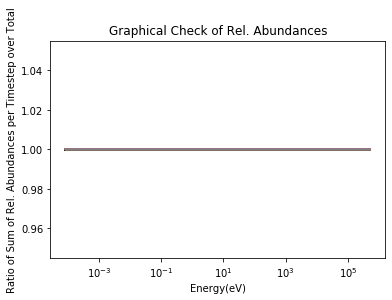

This calculation took 2.90625  sec to graph

 This is for datafile: SkyNet_r-process_0.020000.h5


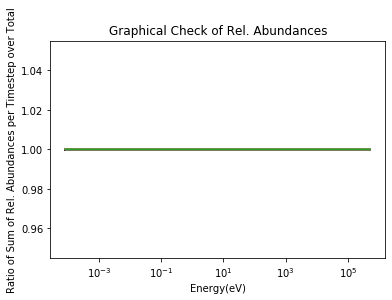

This calculation took 3.90625  sec to graph

 This is for datafile: SkyNet_r-process_0.030000.h5


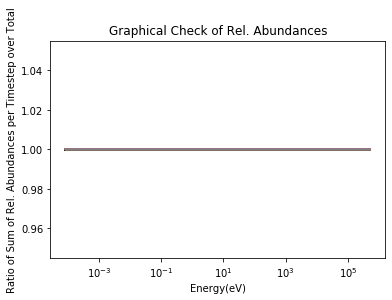

This calculation took 3.65625  sec to graph

 This is for datafile: SkyNet_r-process_0.040000.h5


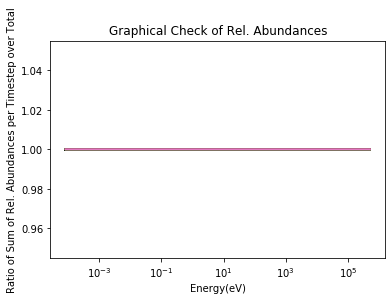

This calculation took 3.125  sec to graph

 This is for datafile: SkyNet_r-process_0.050000.h5


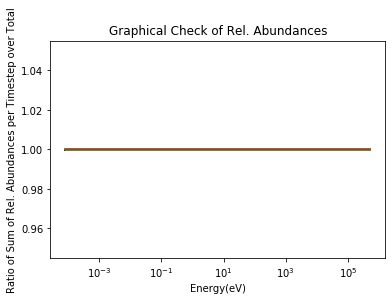

This calculation took 3.171875  sec to graph

 This is for datafile: SkyNet_r-process_0.060000.h5


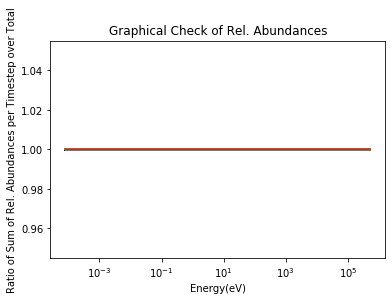

This calculation took 3.5  sec to graph

 This is for datafile: SkyNet_r-process_0.070000.h5


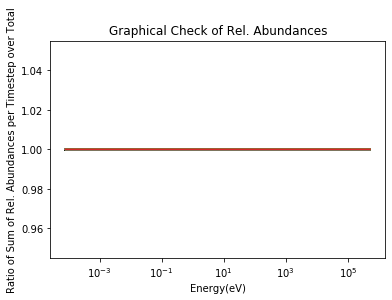

This calculation took 3.5625  sec to graph

 This is for datafile: SkyNet_r-process_0.080000.h5


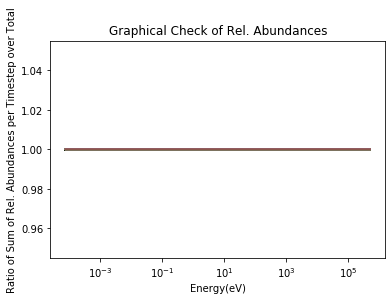

This calculation took 3.65625  sec to graph

 This is for datafile: SkyNet_r-process_0.090000.h5


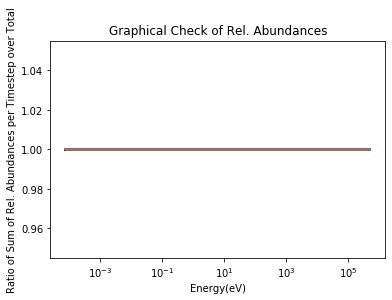

This calculation took 3.203125  sec to graph

 This is for datafile: SkyNet_r-process_0.100000.h5


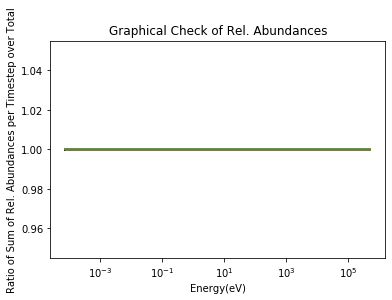

This calculation took 2.875  sec to graph

 This is for datafile: SkyNet_r-process_0.110000.h5


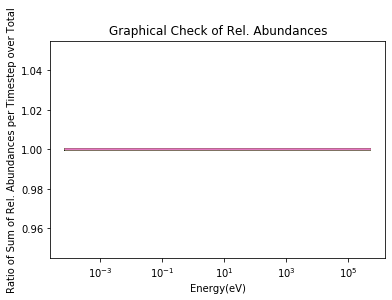

This calculation took 3.078125  sec to graph

 This is for datafile: SkyNet_r-process_0.120000.h5


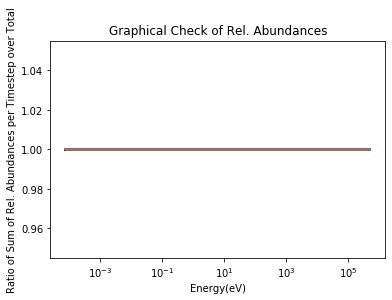

This calculation took 3.296875  sec to graph

 This is for datafile: SkyNet_r-process_0.130000.h5


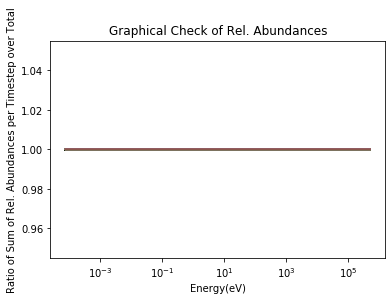

This calculation took 3.28125  sec to graph

 This is for datafile: SkyNet_r-process_0.140000.h5


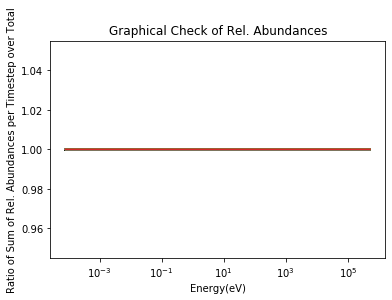

This calculation took 3.078125  sec to graph

 This is for datafile: SkyNet_r-process_0.150000.h5


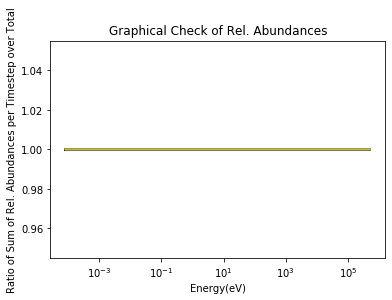

This calculation took 3.140625  sec to graph

 This is for datafile: SkyNet_r-process_0.160000.h5


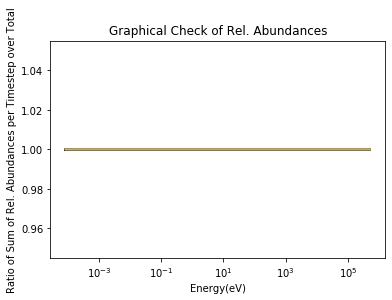

This calculation took 2.96875  sec to graph

 This is for datafile: SkyNet_r-process_0.170000.h5


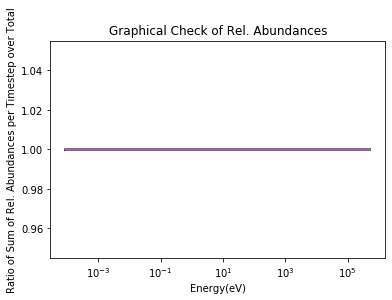

This calculation took 2.734375  sec to graph

 This is for datafile: SkyNet_r-process_0.180000.h5


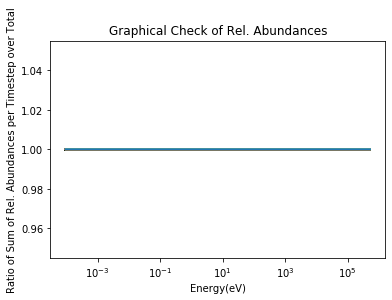

This calculation took 3.109375  sec to graph

 This is for datafile: SkyNet_r-process_0.190000.h5


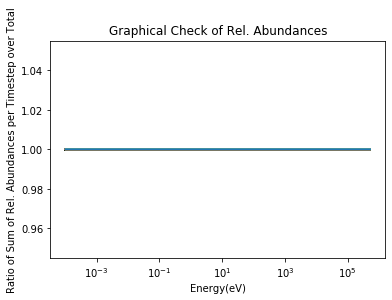

This calculation took 3.0625  sec to graph

 This is for datafile: SkyNet_r-process_0.200000.h5


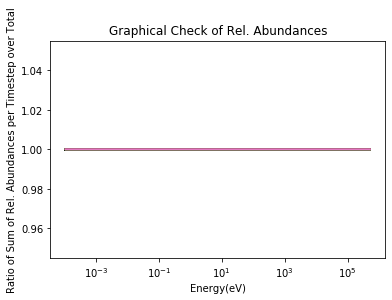

This calculation took 3.46875  sec to graph

 This is for datafile: SkyNet_r-process_0.210000.h5


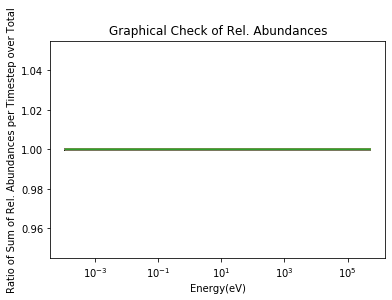

This calculation took 3.015625  sec to graph

 This is for datafile: SkyNet_r-process_0.220000.h5


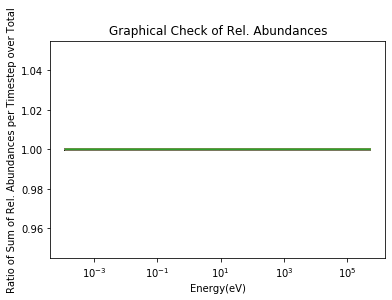

This calculation took 3.03125  sec to graph

 This is for datafile: SkyNet_r-process_0.230000.h5


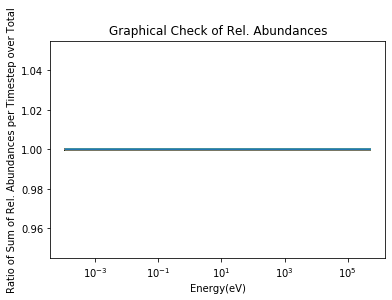

This calculation took 2.609375  sec to graph

 This is for datafile: SkyNet_r-process_0.240000.h5


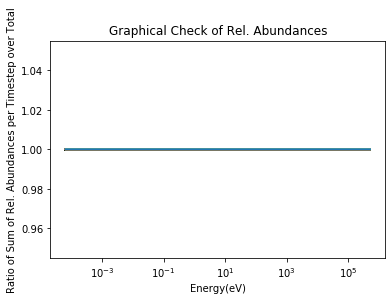

This calculation took 2.75  sec to graph

 This is for datafile: SkyNet_r-process_0.250000.h5


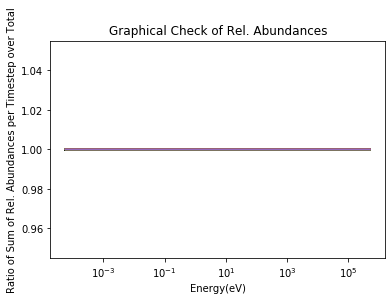

This calculation took 3.234375  sec to graph

 This is for datafile: SkyNet_r-process_0.260000.h5


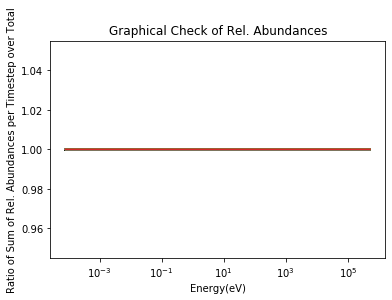

This calculation took 3.65625  sec to graph

 This is for datafile: SkyNet_r-process_0.270000.h5


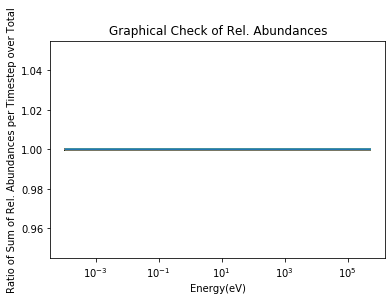

This calculation took 3.40625  sec to graph

 This is for datafile: SkyNet_r-process_0.280000.h5


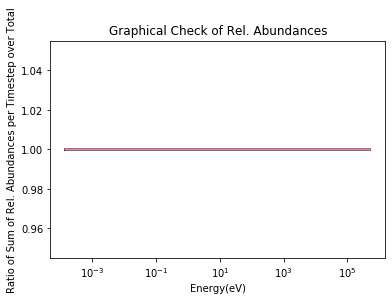

This calculation took 3.03125  sec to graph

 This is for datafile: SkyNet_r-process_0.290000.h5


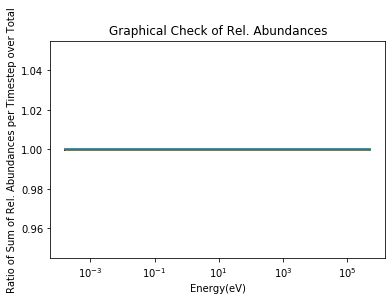

This calculation took 3.03125  sec to graph

 This is for datafile: SkyNet_r-process_0.300000.h5


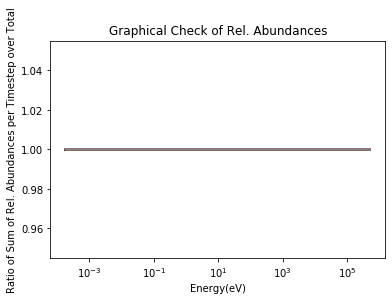

This calculation took 3.0625  sec to graph

 This is for datafile: SkyNet_r-process_0.310000.h5


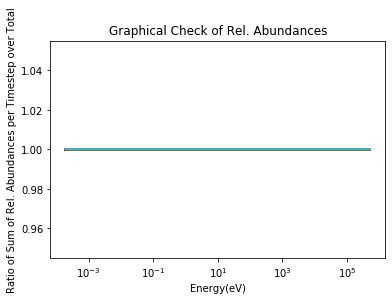

This calculation took 3.125  sec to graph

 This is for datafile: SkyNet_r-process_0.320000.h5


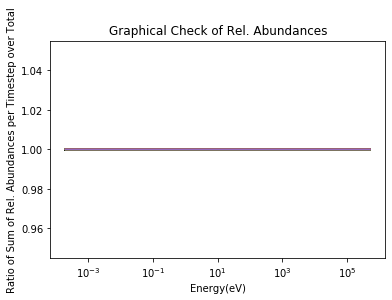

This calculation took 2.65625  sec to graph

 This is for datafile: SkyNet_r-process_0.330000.h5


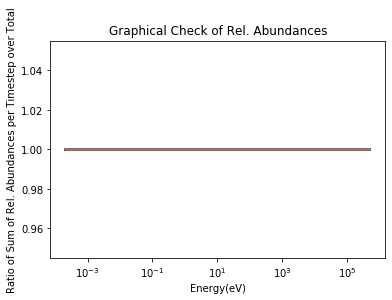

This calculation took 2.53125  sec to graph

 This is for datafile: SkyNet_r-process_0.340000.h5


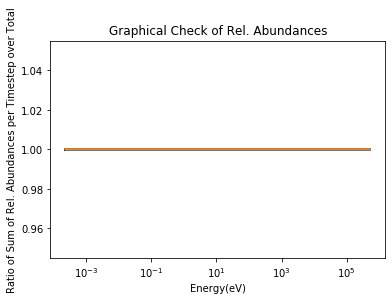

This calculation took 2.484375  sec to graph

 This is for datafile: SkyNet_r-process_0.350000.h5


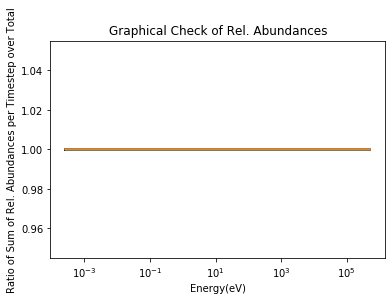

This calculation took 2.390625  sec to graph

 This is for datafile: SkyNet_r-process_0.360000.h5


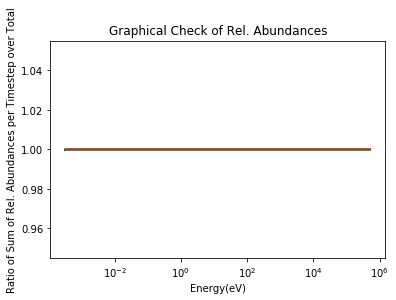

This calculation took 2.21875  sec to graph

 This is for datafile: SkyNet_r-process_0.370000.h5


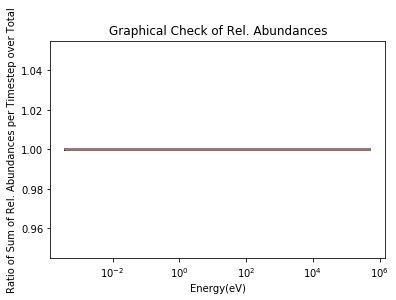

This calculation took 2.03125  sec to graph

 This is for datafile: SkyNet_r-process_0.380000.h5


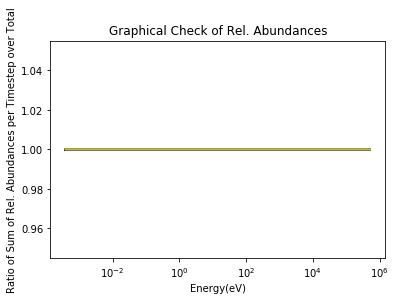

This calculation took 1.84375  sec to graph

 This is for datafile: SkyNet_r-process_0.390000.h5


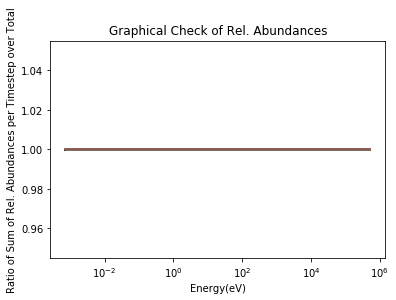

This calculation took 1.390625  sec to graph

 This is for datafile: SkyNet_r-process_0.400000.h5


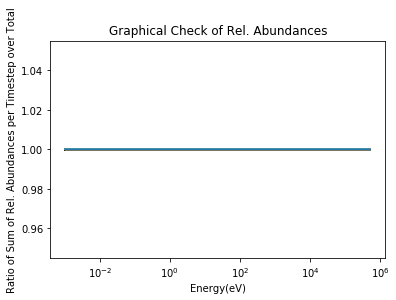

This calculation took 1.3125  sec to graph

 This is for datafile: SkyNet_r-process_0.410000.h5


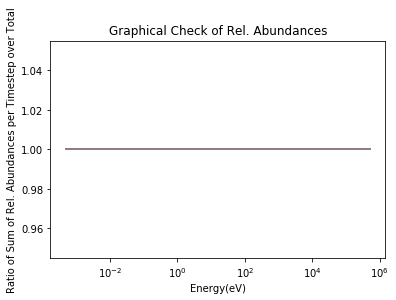

This calculation took 1.171875  sec to graph

 This is for datafile: SkyNet_r-process_0.420000.h5


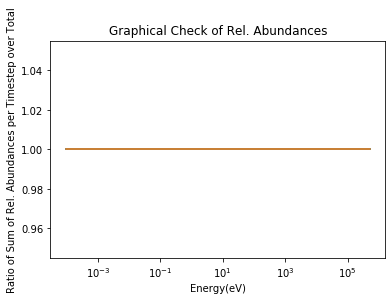

This calculation took 1.15625  sec to graph

 This is for datafile: SkyNet_r-process_0.430000.h5


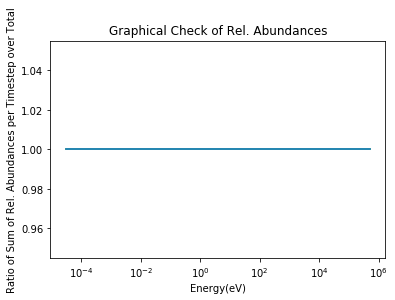

This calculation took 1.015625  sec to graph

 This is for datafile: SkyNet_r-process_0.440000.h5


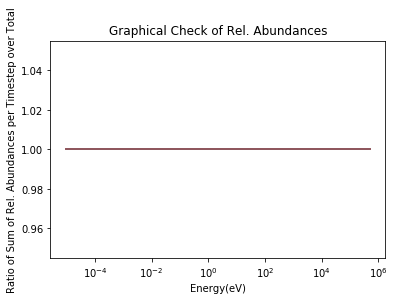

This calculation took 0.78125  sec to graph

 This is for datafile: SkyNet_r-process_0.450000.h5


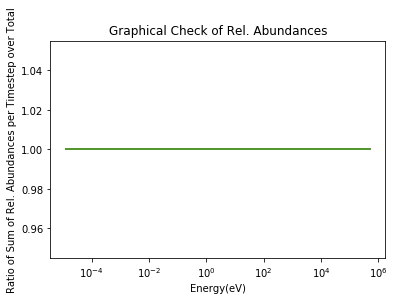

This calculation took 0.578125  sec to graph

 This is for datafile: SkyNet_r-process_0.460000.h5


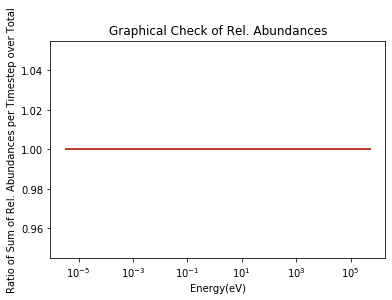

This calculation took 0.609375  sec to graph

 This is for datafile: SkyNet_r-process_0.470000.h5


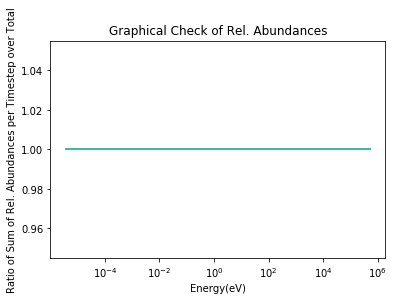

This calculation took 0.6875  sec to graph

 This is for datafile: SkyNet_r-process_0.480000.h5


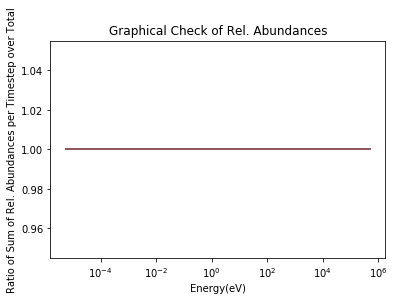

This calculation took 0.8125  sec to graph

 This is for datafile: SkyNet_r-process_0.490000.h5


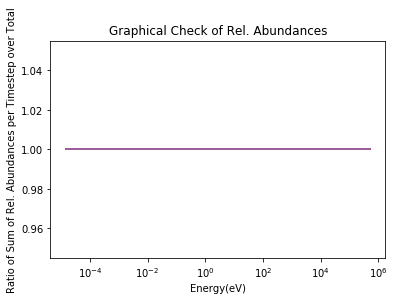

This calculation took 1.234375  sec to graph

 This is for datafile: SkyNet_r-process_0.500000.h5


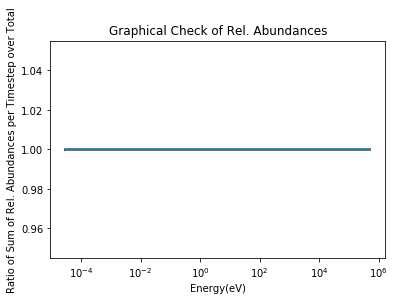

This calculation took 1.28125  sec to graph


In [5]:
directory = './Skynet_Files'
for filename in os.listdir(directory):
    hf = h5py.File(directory + '/' + filename)

    temperature = hf["Temperature"]
    time = hf["Time"]
    mod_temp = []
    full_temp = []

    for i in range(1,len(temperature)):
        if temperature[i-1] / temperature[i] ==1:
            index_cut = i-1
            break

    linear = np.polyfit(np.log10(np.array(time[index_cut-300:index_cut])),np.log10(np.array(temperature[index_cut-300:index_cut])),1)
    m = linear[0]

    for i in range(0,len(temperature)):
        if i < index_cut:
            mod_temp.append(np.log10(temperature[i]))
            full_temp.append(temperature[i])
        else:
            del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
            mod_temp.append(mod_temp[i-1]+del_t)
            full_temp.append(10**mod_temp[i])
            
    YI,bad,Ye_free,Ye_bound,Ye_f_Mid = abundance_calculation([8,9])
    print("\n This is for datafile: "+filename)
    plotter(YI)
    plt.show()


C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:137: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:138: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:149: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


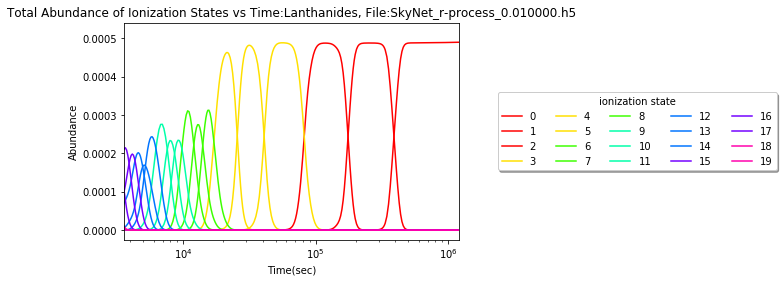

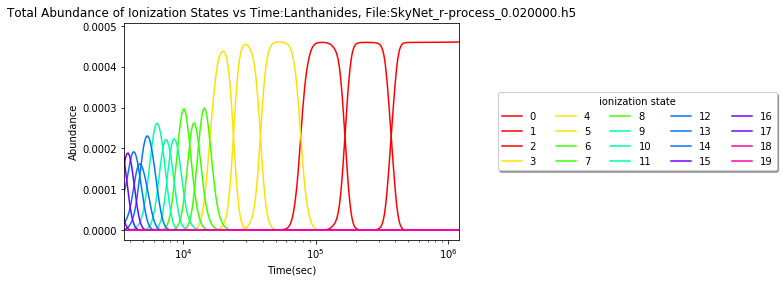

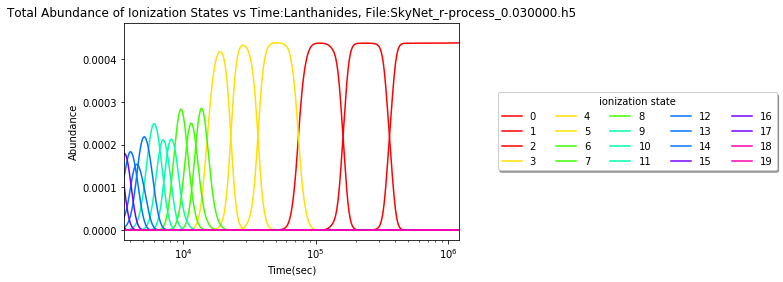

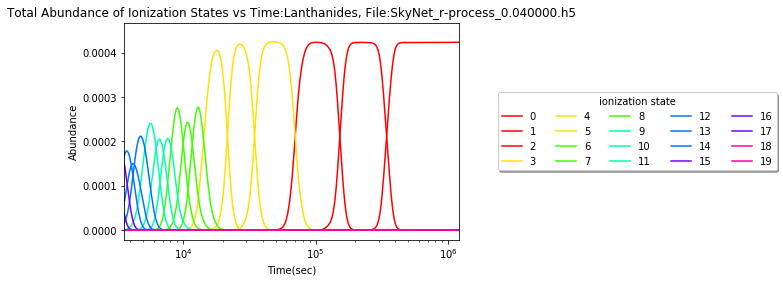

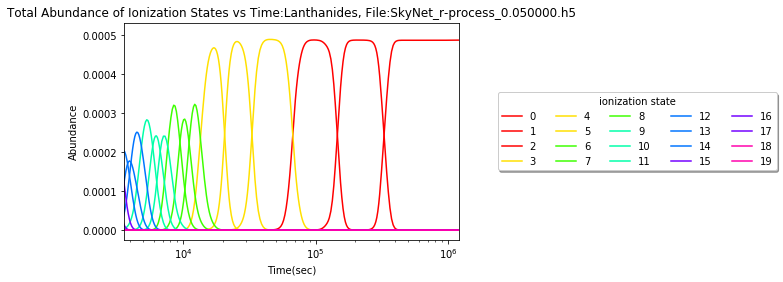

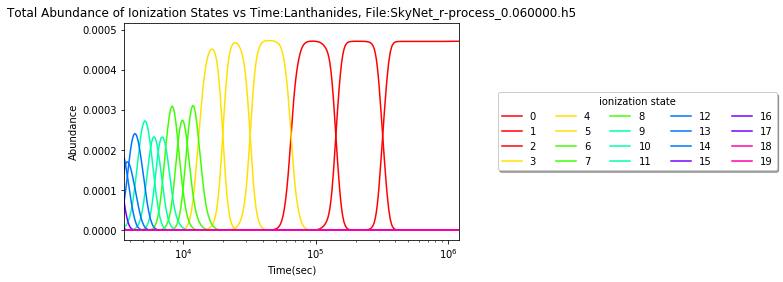

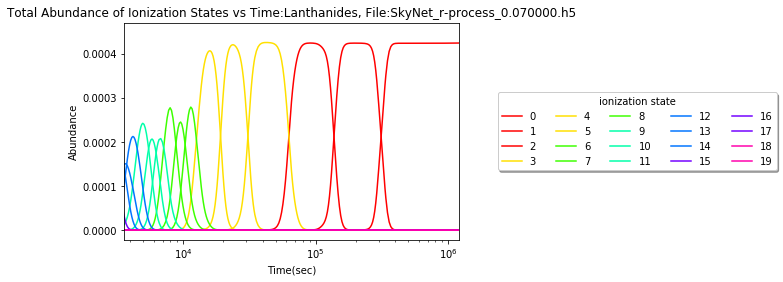

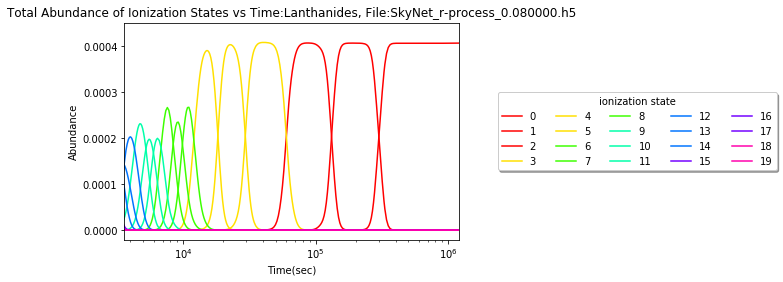

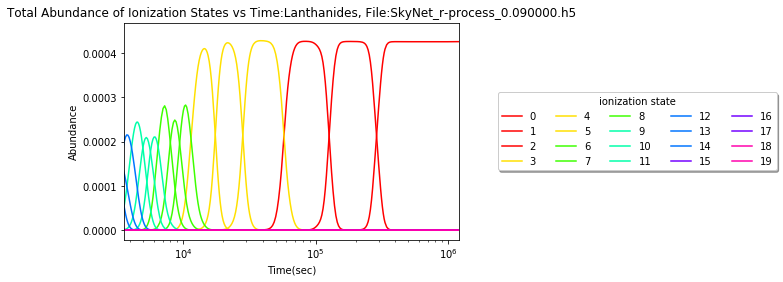

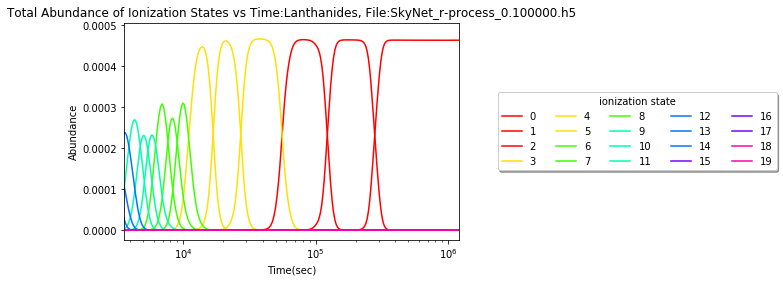

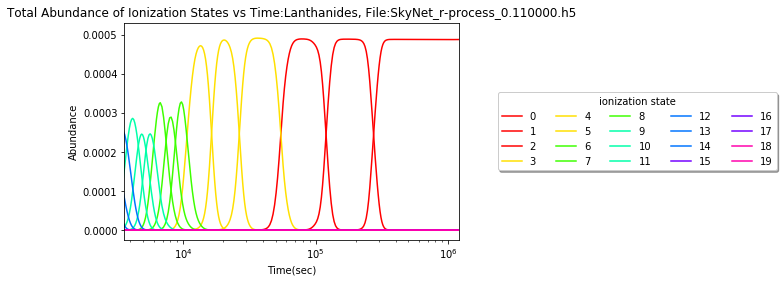

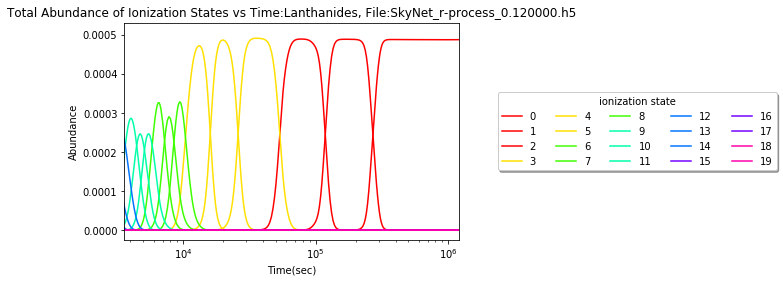

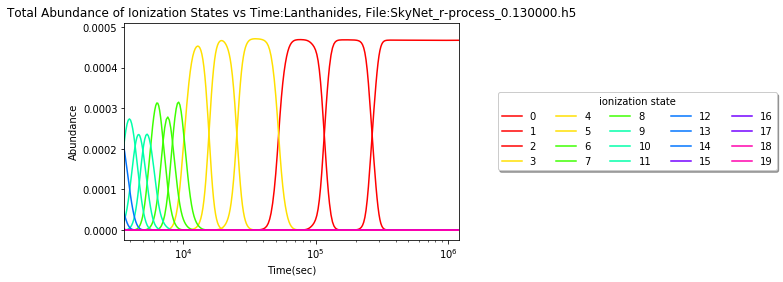

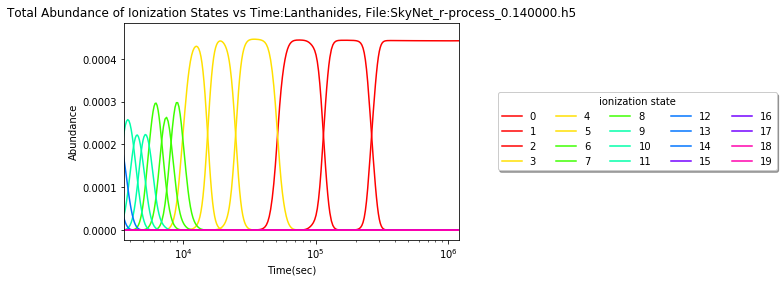

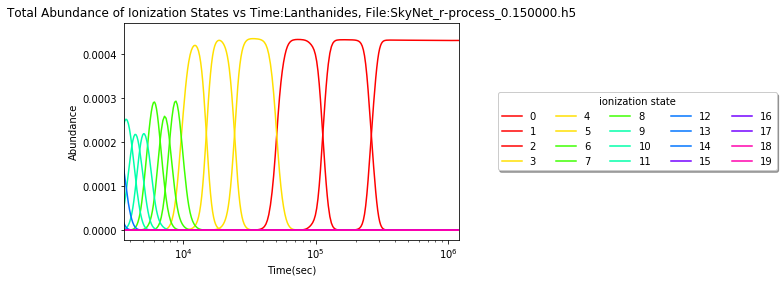

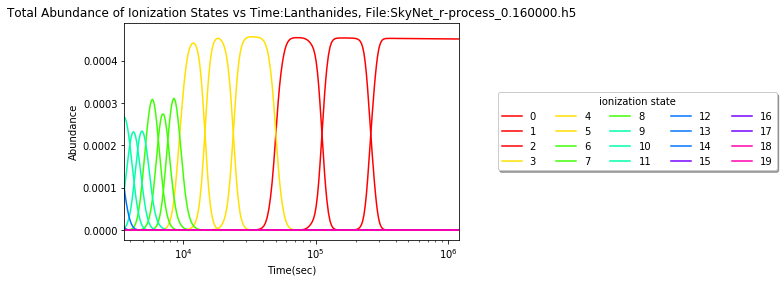

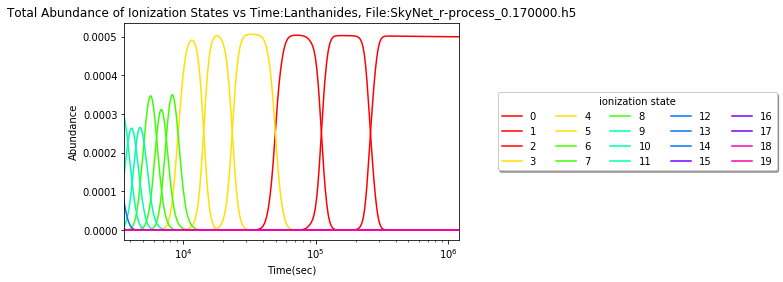

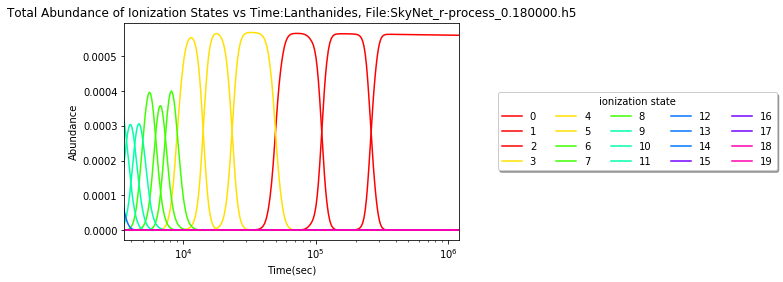

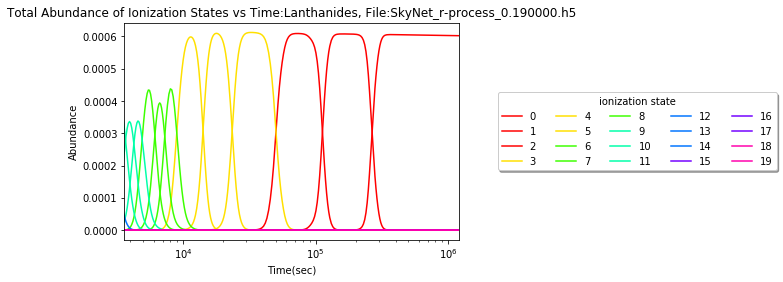

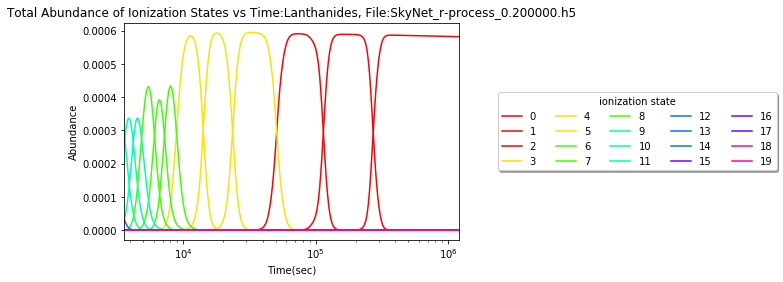

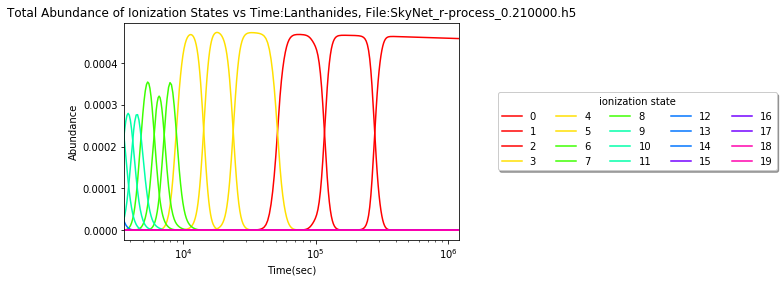

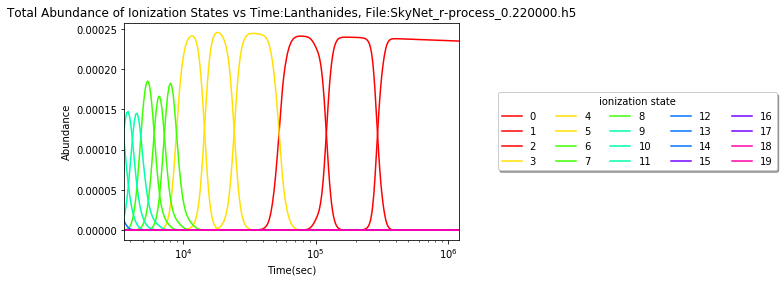

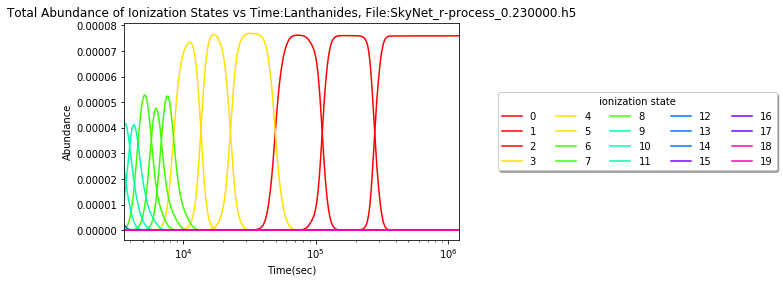

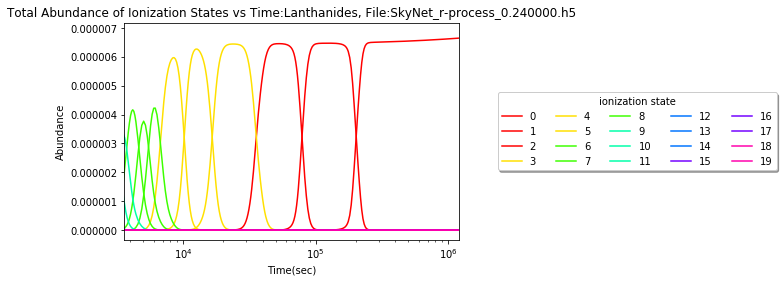

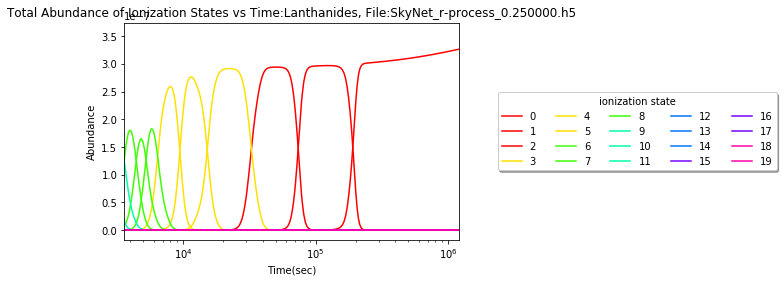

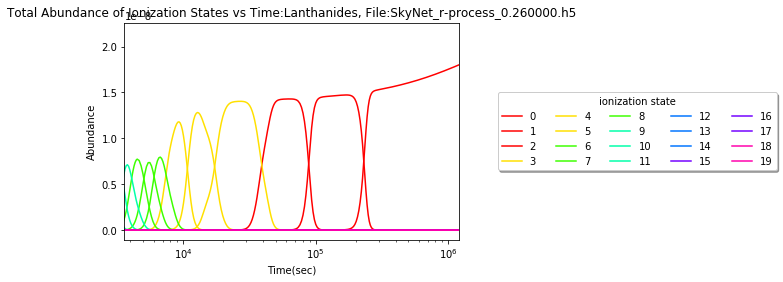

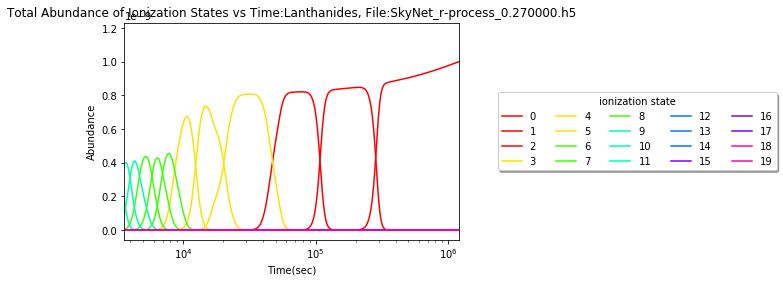

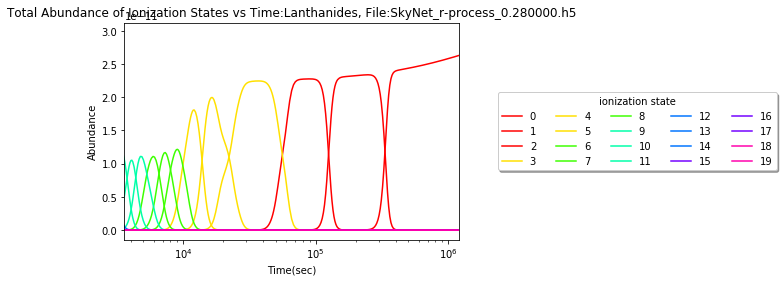

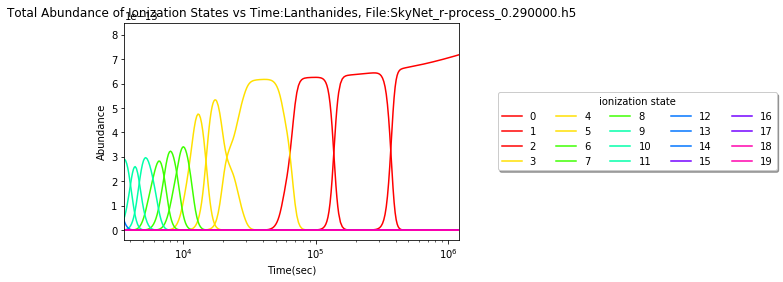

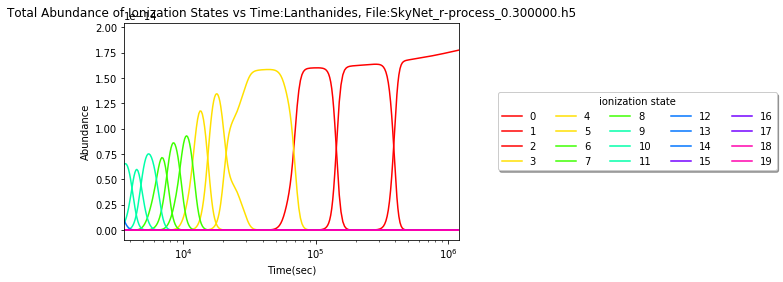

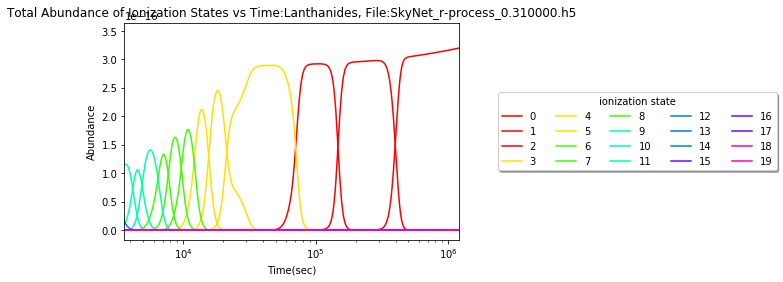

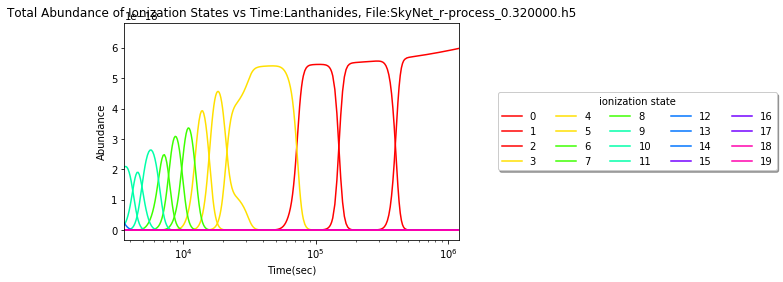

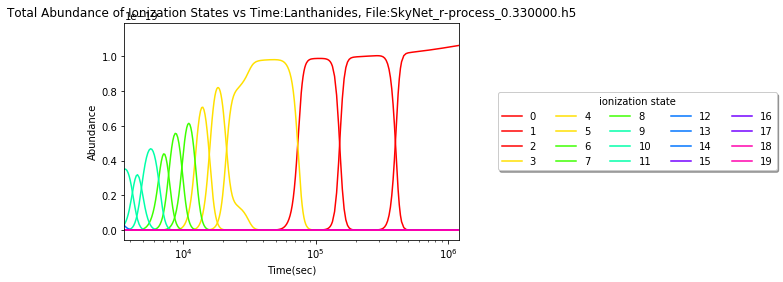

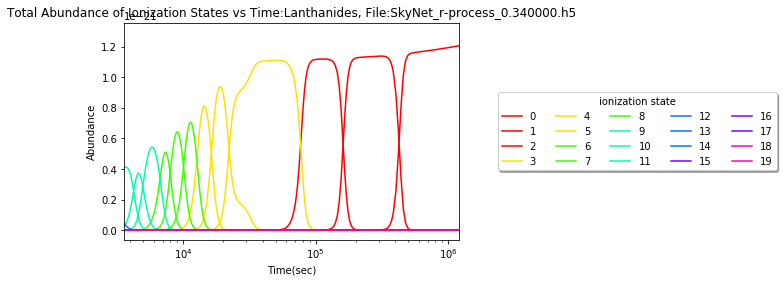

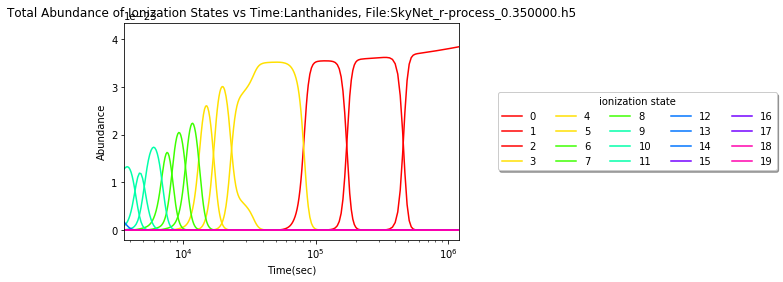

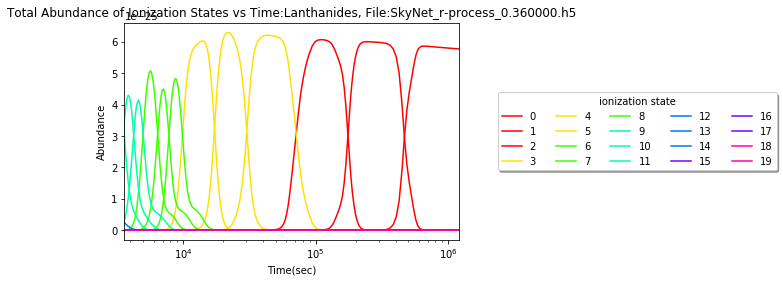

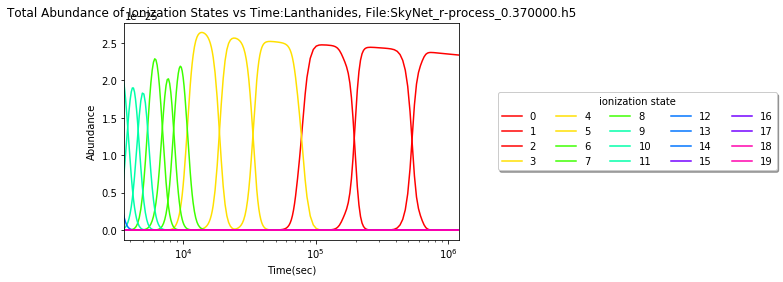

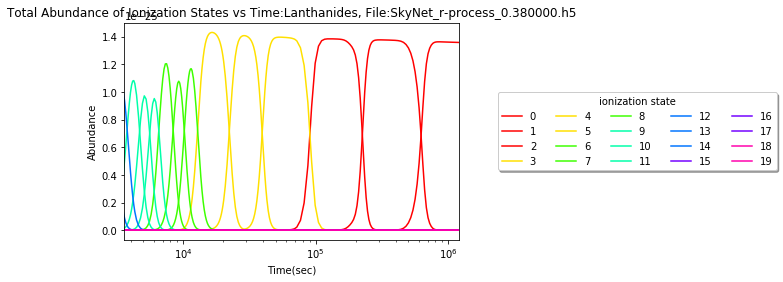

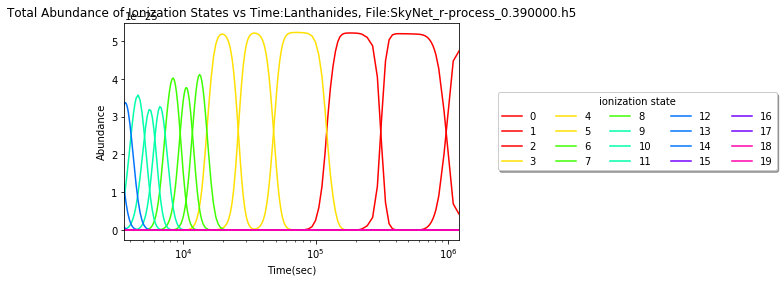

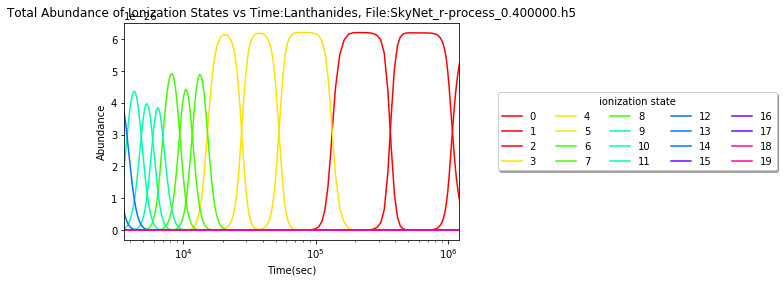

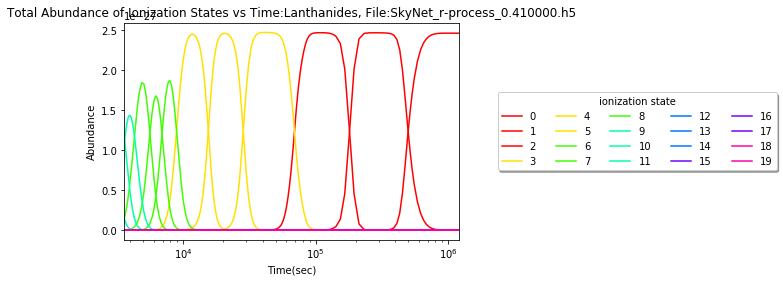

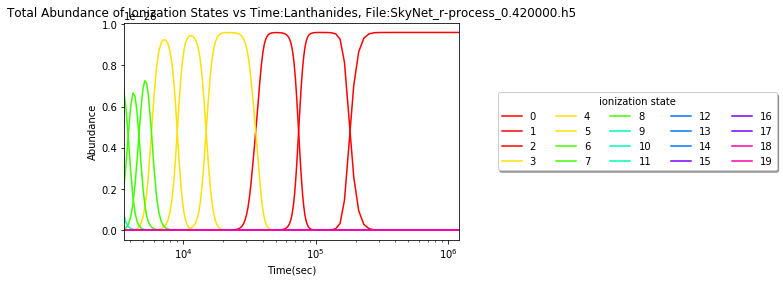

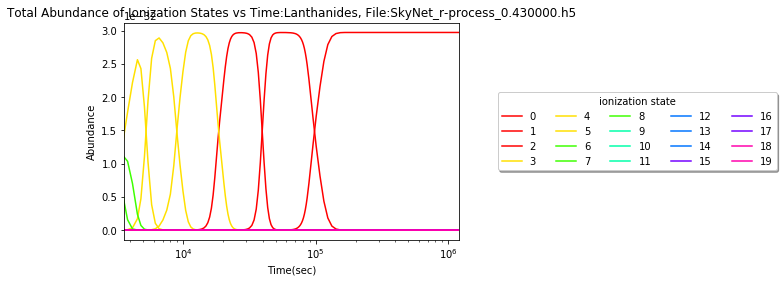

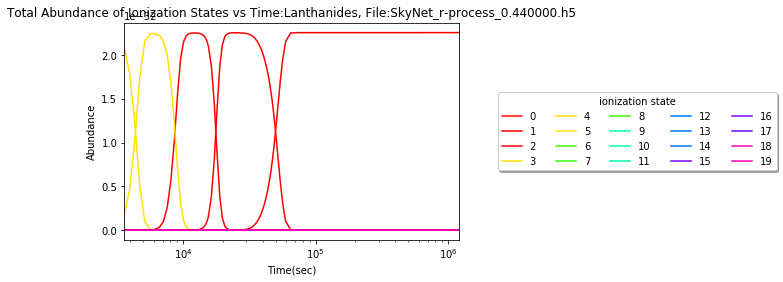

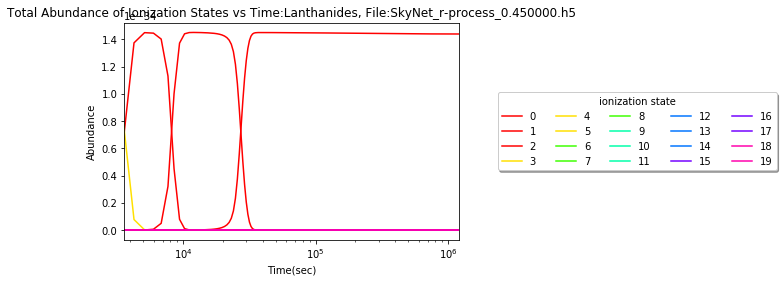

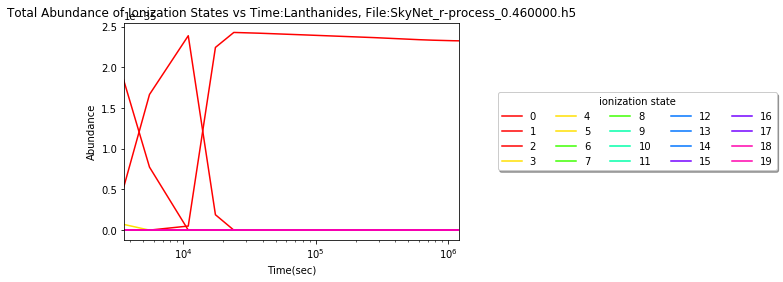

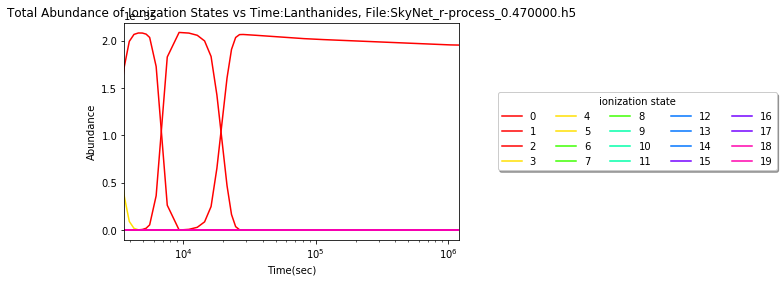

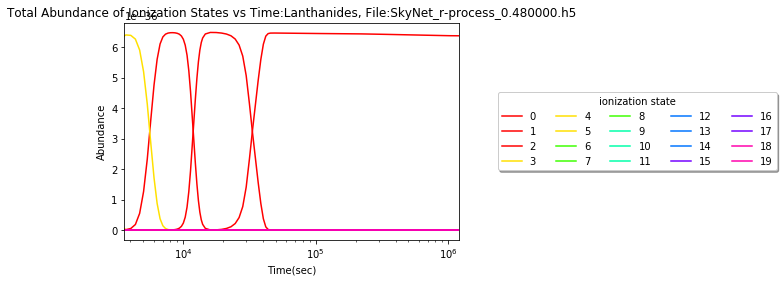

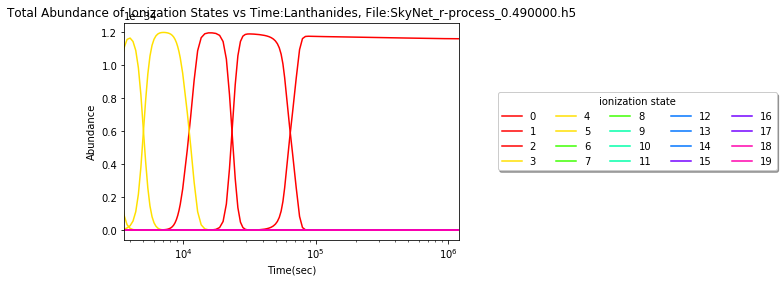

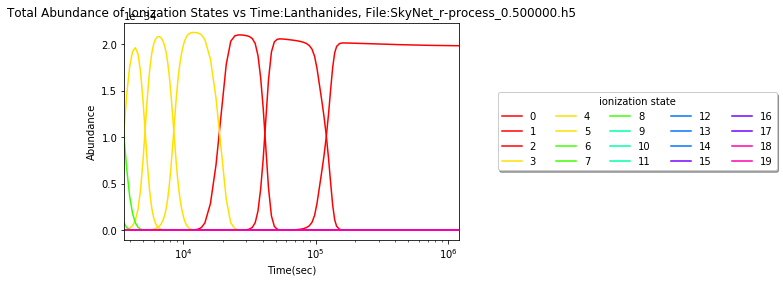

This calculation across 50 Ye datasets took: 7970.953125


In [9]:
time_start = process_time()
k=0

directory = './Skynet_Files'
for filename in os.listdir(directory):
    hf = h5py.File(directory + '/' + filename)

    temperature = hf["Temperature"]
    time = hf["Time"]
    mod_temp = []
    full_temp = []

    for i in range(1,len(temperature)):
        if temperature[i-1] / temperature[i] ==1:
            index_cut = i-1
            break

    linear = np.polyfit(np.log10(np.array(time[index_cut-300:index_cut])),np.log10(np.array(temperature[index_cut-300:index_cut])),1)
    m = linear[0]

    for i in range(0,len(temperature)):
        if i < index_cut:
            mod_temp.append(np.log10(temperature[i]))
            full_temp.append(temperature[i])
        else:
            del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
            mod_temp.append(mod_temp[i-1]+del_t)
            full_temp.append(10**mod_temp[i])
            
    YI,bad,Ye_free,Ye_bound,Ye_f_Mid = abundance_calculation(np.arange(1,104,1))
    
    charge_abundances = [] 

    for i in range(np.shape(YI[70])[1]):
        specific = np.zeros((len(time)))
        for j in range(56,71):
            if i < np.shape(YI[j])[1]:
                #print(i)
                specific+=YI[j][:,i]
        charge_abundances.append(specific)
        
    n = 20
    cm = plt.get_cmap('hsv') #Using prism highlights groups of 3. very useful. same with hsv

    for i in range(0,n,1):
        plt.semilogx(np.array(time),charge_abundances[i],label = i,color = cm(i//3*3.0/n))
        plt.xlabel("Time(sec)")
        plt.ylabel("Abundance")
        plt.title('Total Abundance of Ionization States vs Time:Lanthanides, File:' + filename)
        plt.xlim([3600,1.21e+6])
    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'ionization state',ncol = 5)
    
    string = './Animations/'+'lanth-'+'{:03d}'.format(k)
    plt.savefig(string)
    k+=1
    
    plt.show()
    
print('This calculation across 50 Ye datasets took:',process_time() - time_start)

In [10]:
def initialization(elements):

    full_abundance = []
    ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance),np.array(ion_potential)

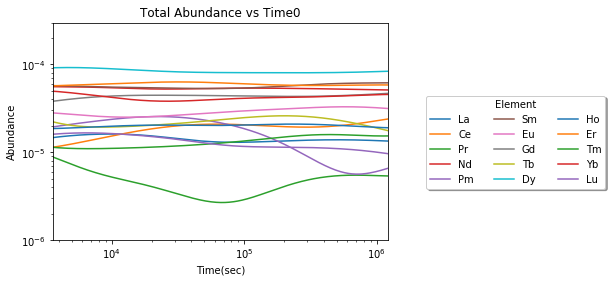

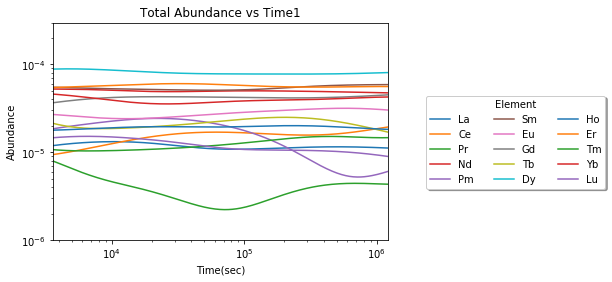

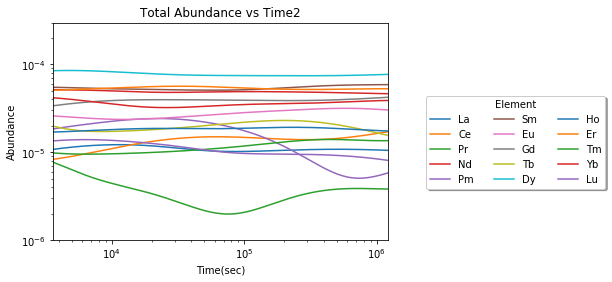

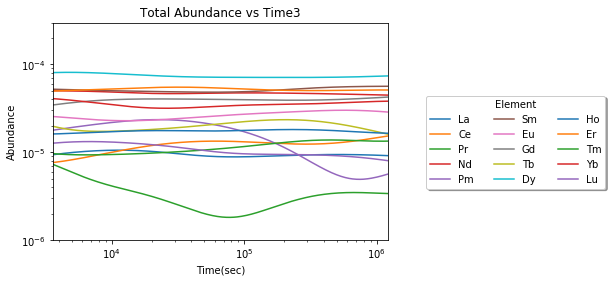

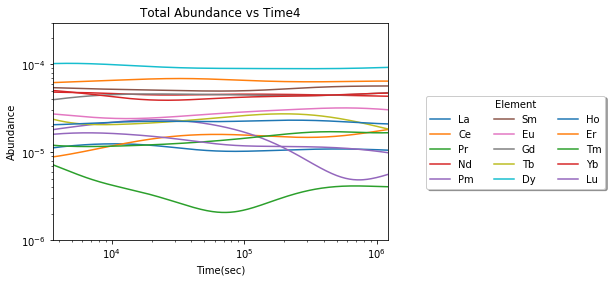

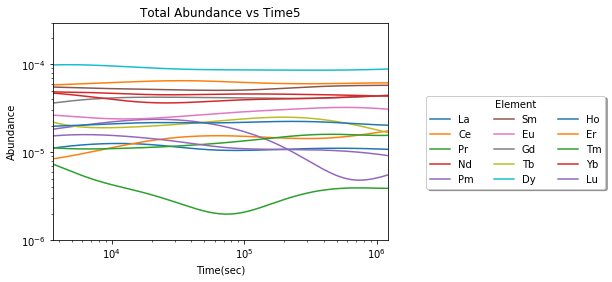

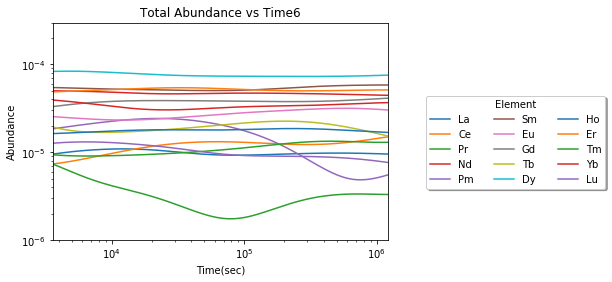

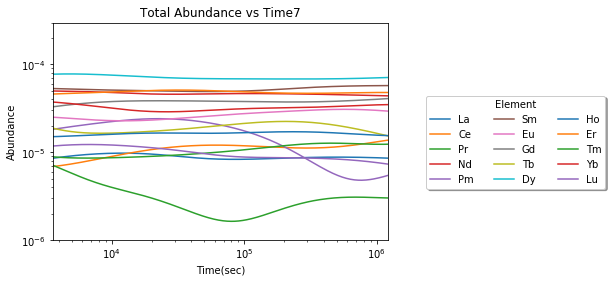

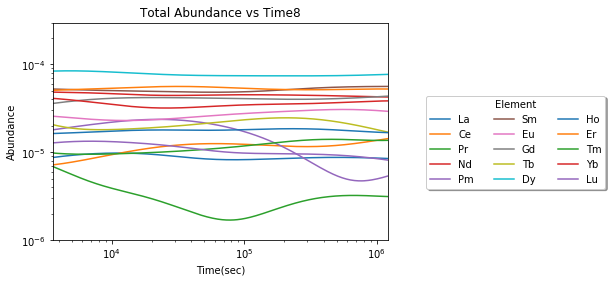

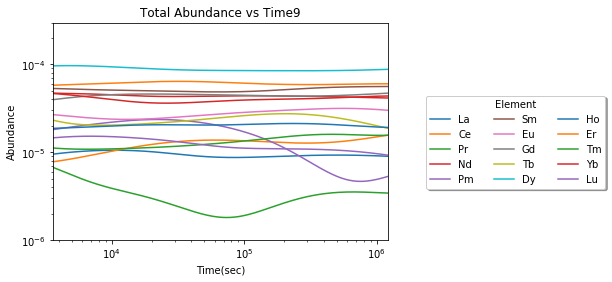

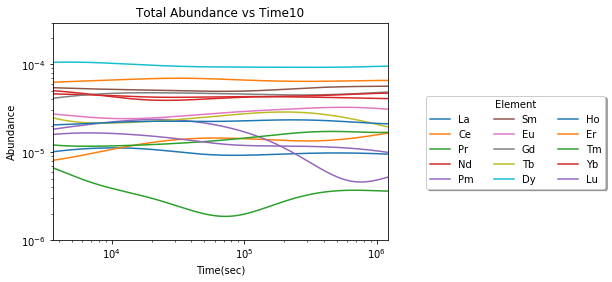

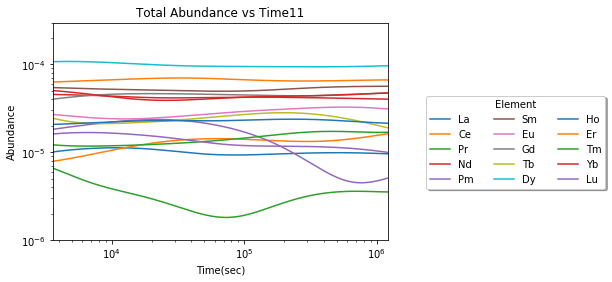

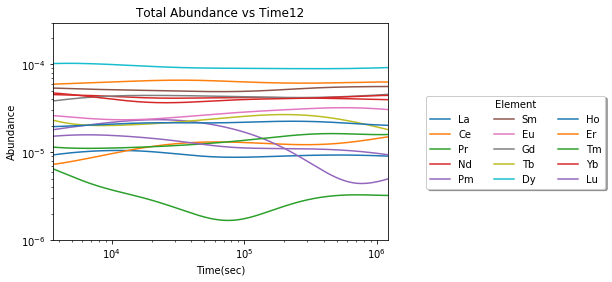

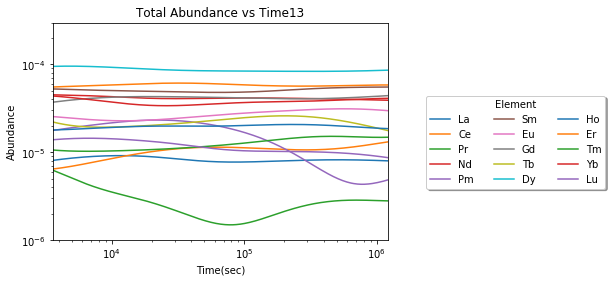

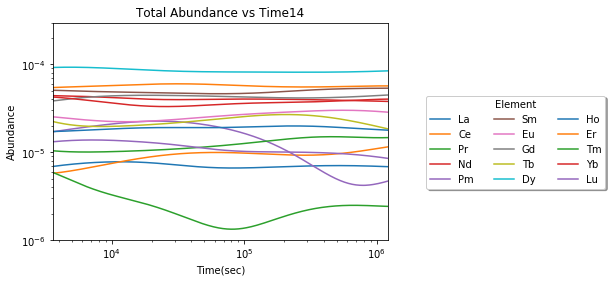

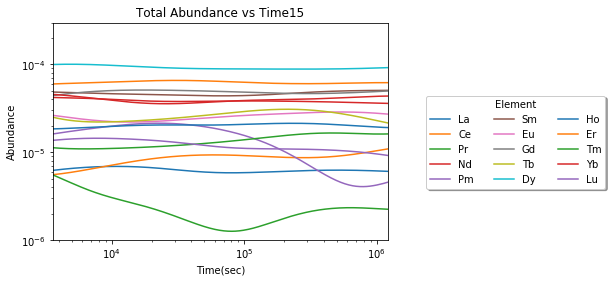

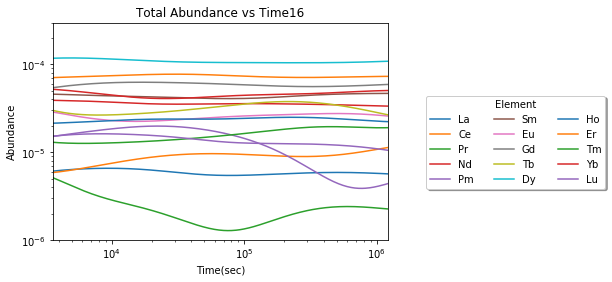

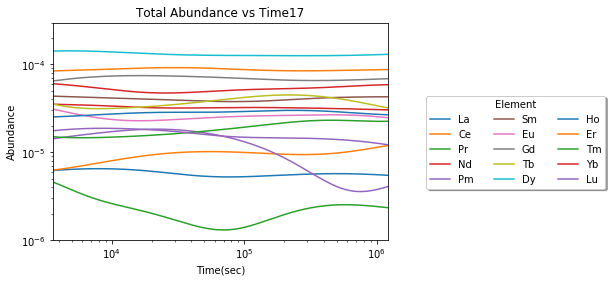

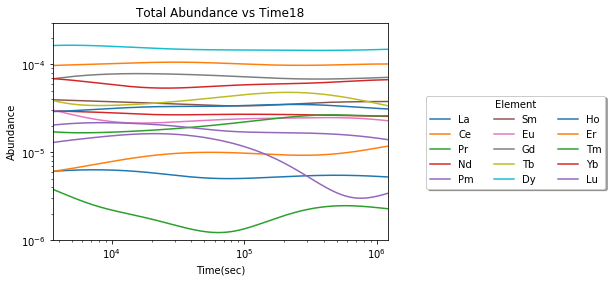

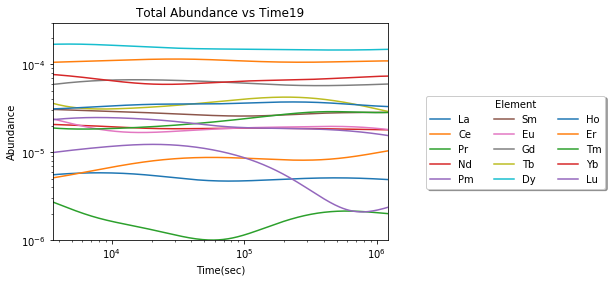

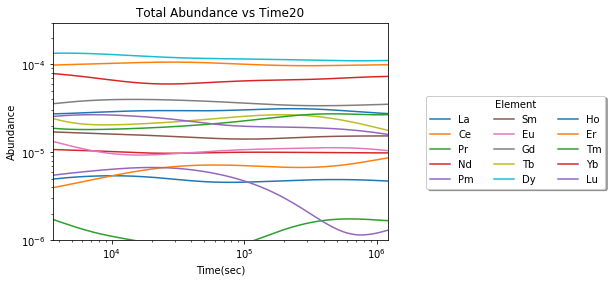

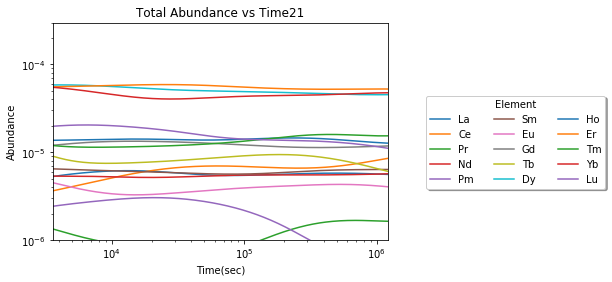

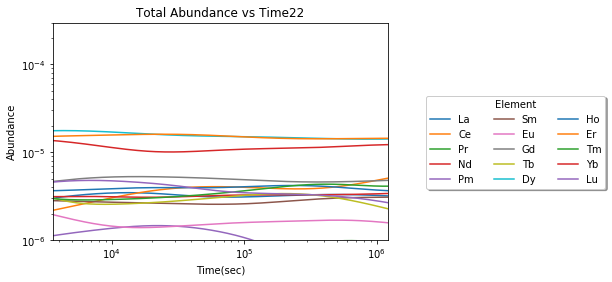

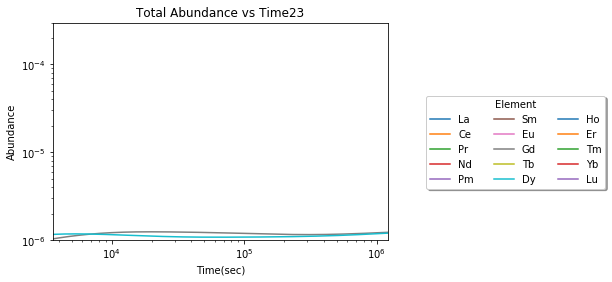

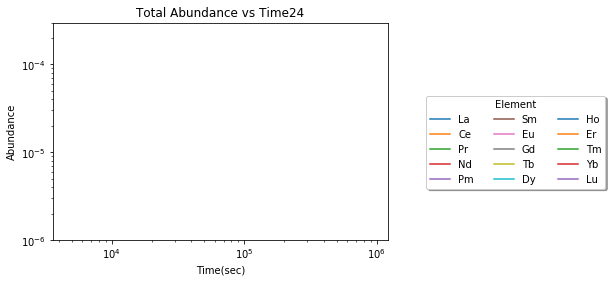

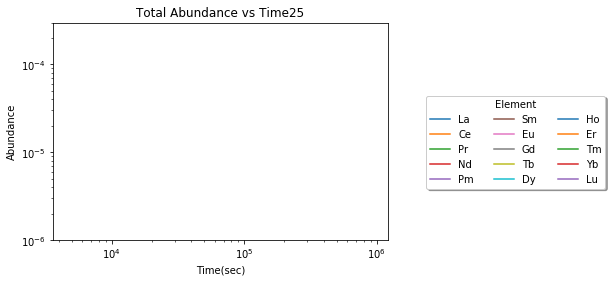

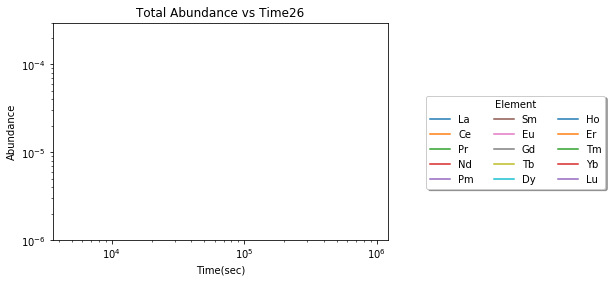

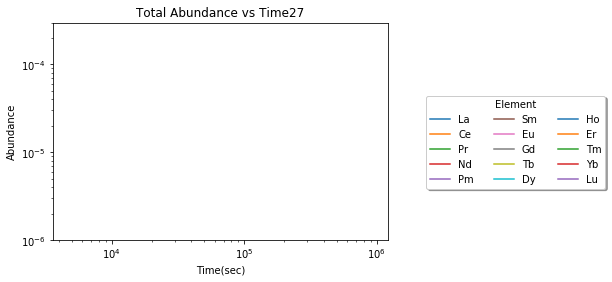

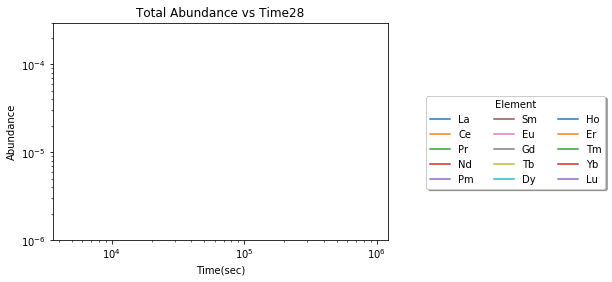

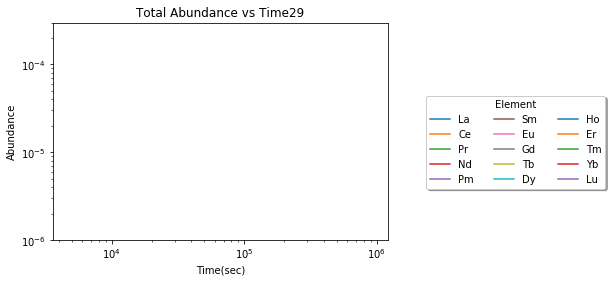

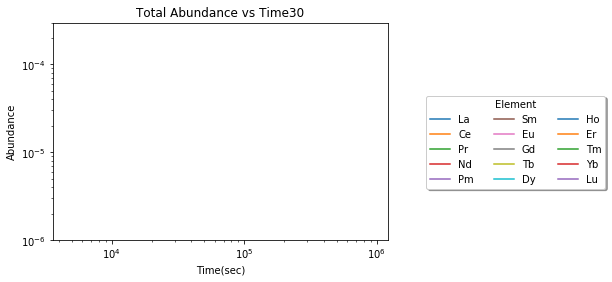

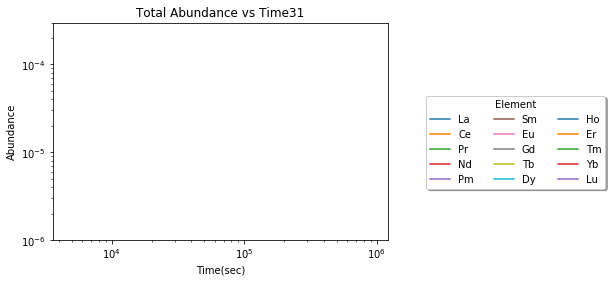

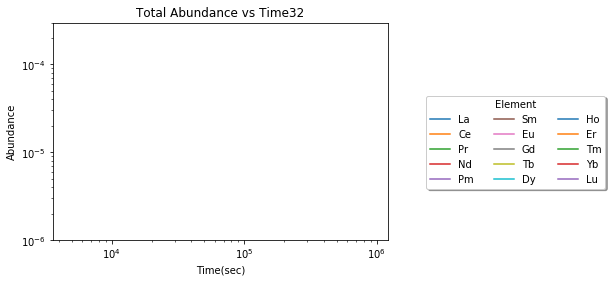

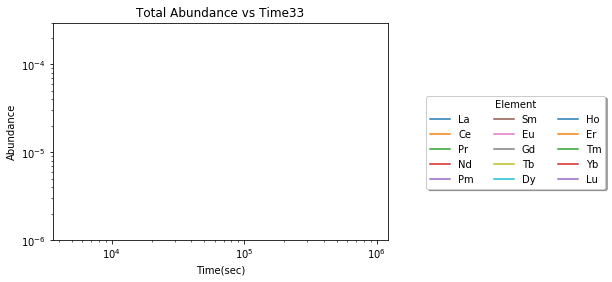

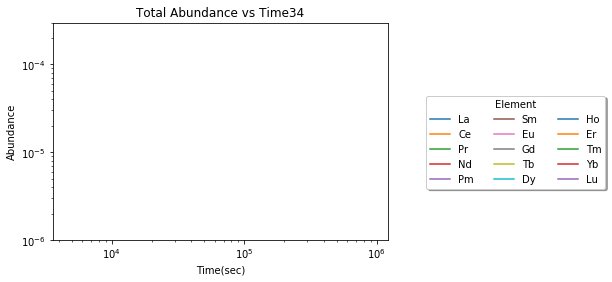

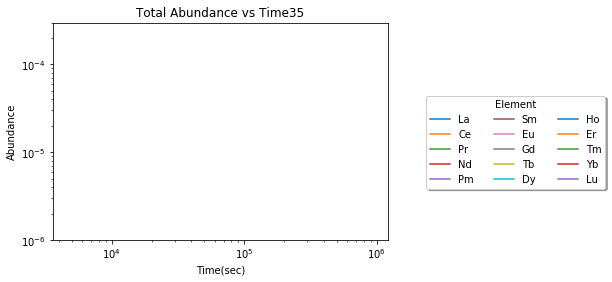

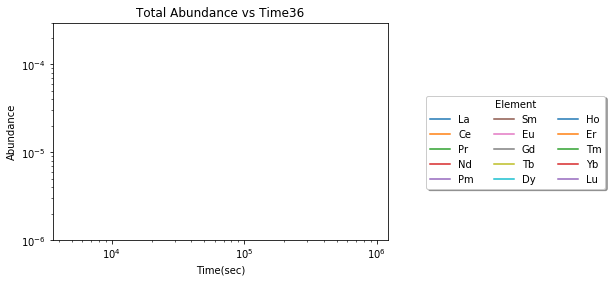

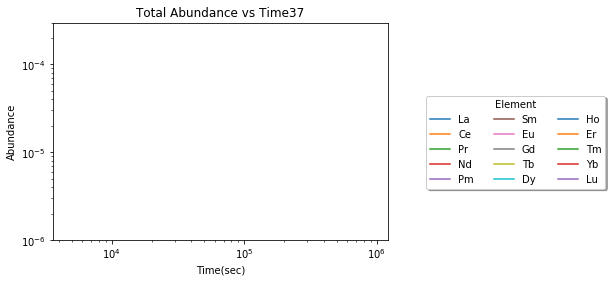

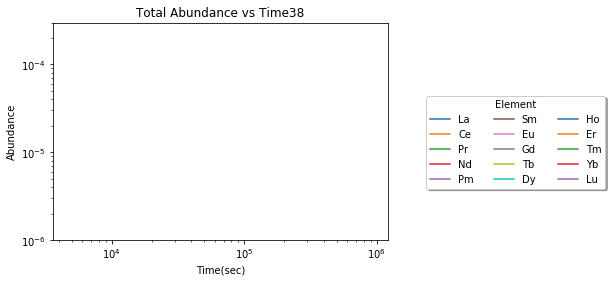

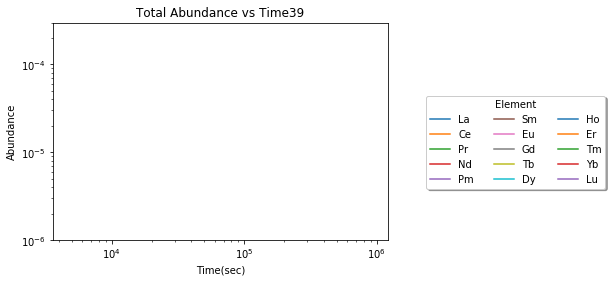

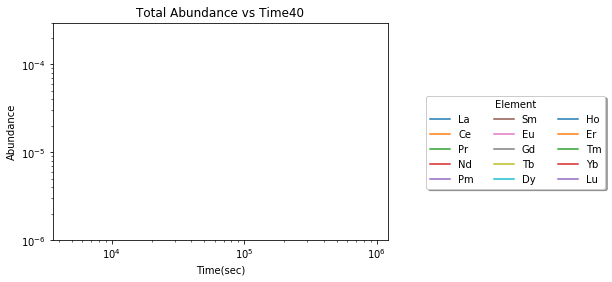

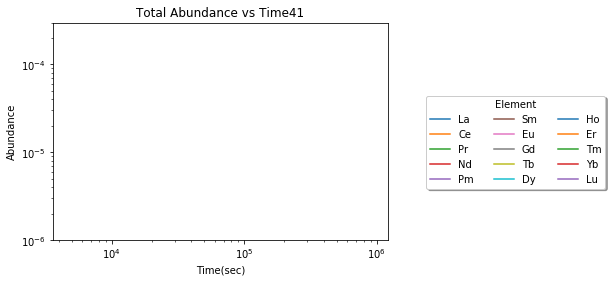

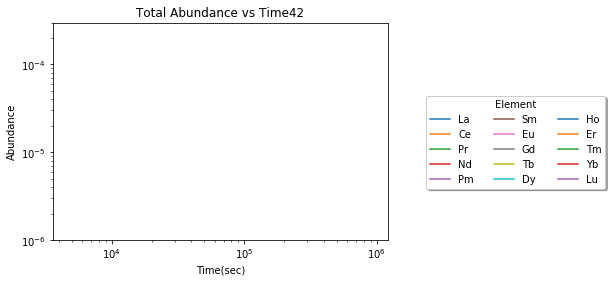

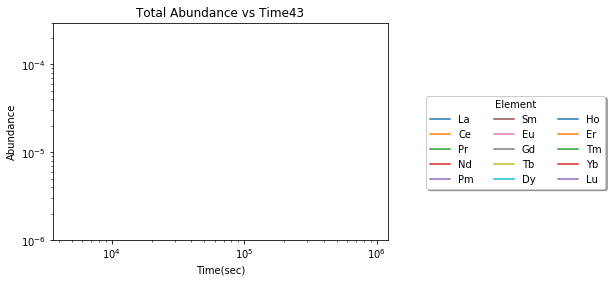

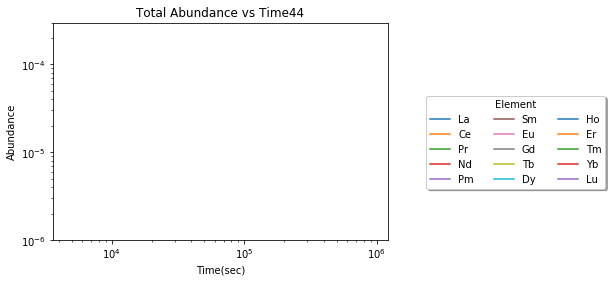

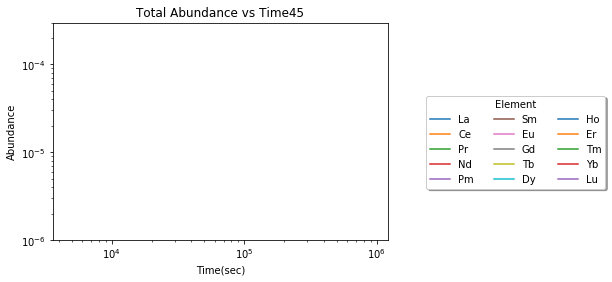

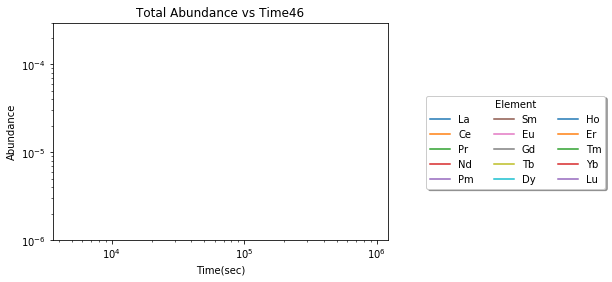

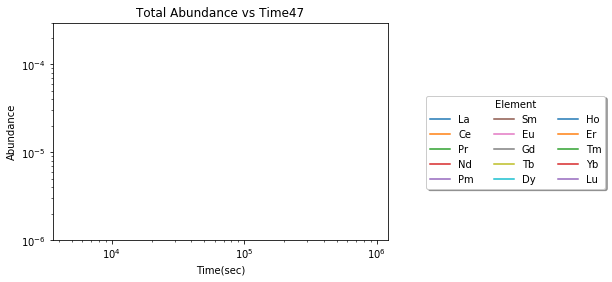

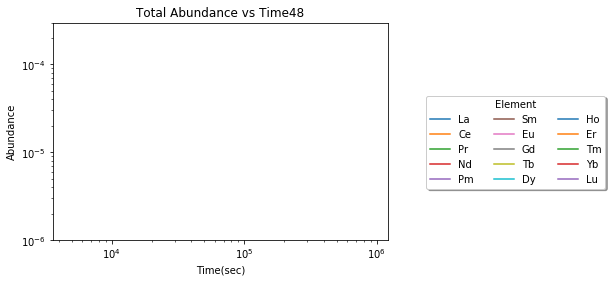

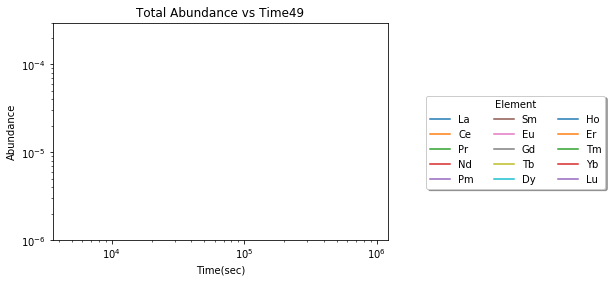

In [12]:
#Making animation useful for understanding lanthanide abundances across time
directory = './Skynet_Files'
lanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
k = 1

for filename in os.listdir(directory):
    hf = h5py.File(directory + '/' + filename)
    
    abundance = hf["Y"]
    charge = hf["Z"]
    time = hf['Time']
    
    elemental,potentials = initialization(np.arange(1,104,1))   
    
    for i in range(56,71):
        plt.loglog(time,elemental[i],label = lanthanide_names[i-56])
        plt.xlim(3600,1209600)
        plt.ylim(1e-6,3e-4)
        plt.title('Total Abundance vs Time'+str(k))
        plt.xlabel('Time(sec)')
        plt.ylabel('Abundance')
    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.45),shadow = True,fancybox = True,title = 'Element',ncol = 3)
        
    string = './Animations/'+'image-'+'{:03d}'.format(k)
    plt.savefig(string)
    k+=1
    plt.show()
        